# Jigsaw Cropped Gardens

Use the jigsaw function defined in ppp07 & ppp08 to jigsaw cut out the cropped garden polygons defined in ppp10 from the Aerial Photography RGB and IRG (Infra-red, Red, Green channels only)f tif files.

## Libraries

In [120]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

import glob

import earthpy as et 
import earthpy.spatial as es 
import earthpy.plot as ep #to plot np array of RGB pixel numbers
import cartopy as cp

import mplleaflet
import folium
import fiona
import pyproj
import contextily
import shapely as shp

import rasterio
from rasterio._base import gdal_version
#https://rasterio.readthedocs.io/en/latest/
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct position, and full RGB 

from rasterio.mask import mask

#check correct environment is being used: parkprov
print(sys.executable)

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


## Read in cropped garden polygons

Created in ppp10 from the intersection of the roadside garden polygons and the 9m buffered linestring of the roadside edge of each garden polygon. Gardens with roadside edge less than 2m were dropped. So were any Multilinestring instances, where the roadside edge was discontinuous.

In [26]:
#cg: cropped gardens
#read in as strings
cg = pd.read_csv("../data/cropped_gardens.csv"
                 , dtype={'gdnTOID': object, 'geometry': object})
#convert WKT strings to geometry
cg['geometry'] = cg['geometry'].map(shp.wkt.loads)
#convert to geodataframe and set CRS
cg = gpd.GeoDataFrame(cg, crs="EPSG:27700", geometry="geometry")

In [29]:
cg.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: UK - Britain and UKCS 49°46'N to 61°01'N, 7°33'W to 3°33'E
- bounds: (-9.2, 49.75, 2.88, 61.14)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

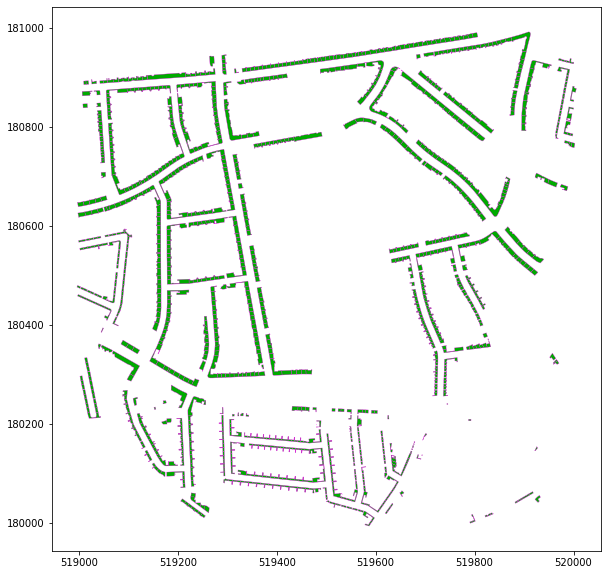

In [37]:
cg.plot(figsize = (10,10), color = '#00AA00', edgecolor = 'magenta', linewidth = 0.3)

In [38]:
cg.head()
#gdnTOID reference to OS garden shape
#geometry cropped at 9m perpendicular distance to roadside edge

,gdnTOID,geometry
0,0001000003513170,"POLYGON ((519327.150 180219.550, 519329.100 18..."
1,1000001778258479,"POLYGON ((519684.949 180970.923, 519685.728 18..."
2,1000001778258579,"POLYGON ((519666.761 180968.013, 519667.537 18..."
3,1000001778258580,"POLYGON ((519693.713 180972.325, 519694.467 18..."
4,1000001778258608,"POLYGON ((519712.133 180975.268, 519712.903 18..."


In [68]:
cg.geometry.name

'geometry'

## Load AP TQ1980 RGB

In [39]:
ealing_tif_paths = glob.glob(
    '../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/*.tif', recursive=True)
ealing_tif_paths[10]

'../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ1980.tif'

In [40]:
rgb = rasterio.open(ealing_tif_paths[10])
print("path: ", rgb.name, "\nmode: ", rgb.mode, "\nis closed?: ", rgb.closed
      , "\nband count: ", rgb.count, "\nshape: ", rgb.shape)

path:  ../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ1980.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (4000, 4000)


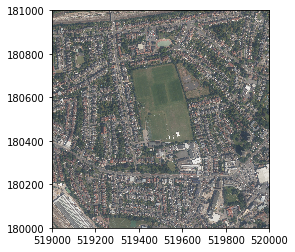

In [41]:
#make sure 'from rasterio import plot' is run ffs
plot.show(rgb)

## Load AP TQ1980 RGB-I

In [42]:
#get path for TQ1980 AP IRG
irgTQ1980 = '../data/APGB_Ealing_InfraRedImagery/111803_20200707/50cm Colour Infrared/111803-1_CIR_1_Shape/TQ1980.tif'


In [43]:
irg = rasterio.open(irgTQ1980)
print("path: ", irg.name, "\nmode: ", irg.mode, "\nis closed?: ", irg.closed
      , "\nband count: ", irg.count, "\nshape: ", irg.shape)

path:  ../data/APGB_Ealing_InfraRedImagery/111803_20200707/50cm Colour Infrared/111803-1_CIR_1_Shape/TQ1980.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (2000, 2000)


In [67]:
irg.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 2000,
 'height': 2000,
 'count': 3,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(0.5, 0.0, 519000.0,
        0.0, -0.5, 181000.0)}

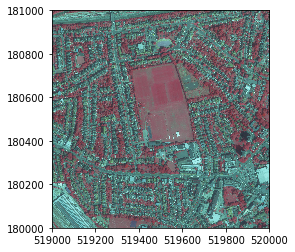

In [44]:
plot.show(irg)

## Check cropped gardens overlap rasters

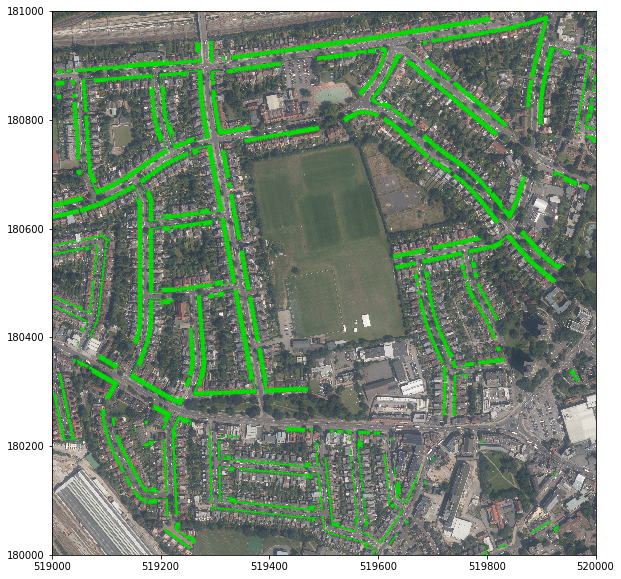

In [65]:
base = cg.plot(figsize=(10,10), color = '#00DD00')
plot.show(rgb, ax = base) #uses rasterio plot module

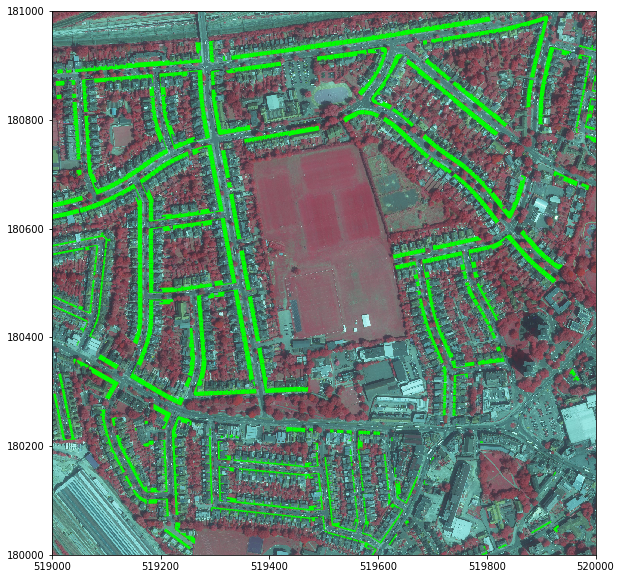

In [139]:
base = cg.plot(figsize=(10,10), color = '#00FF00')
plot.show(irg, ax = base) #uses rasterio plot module

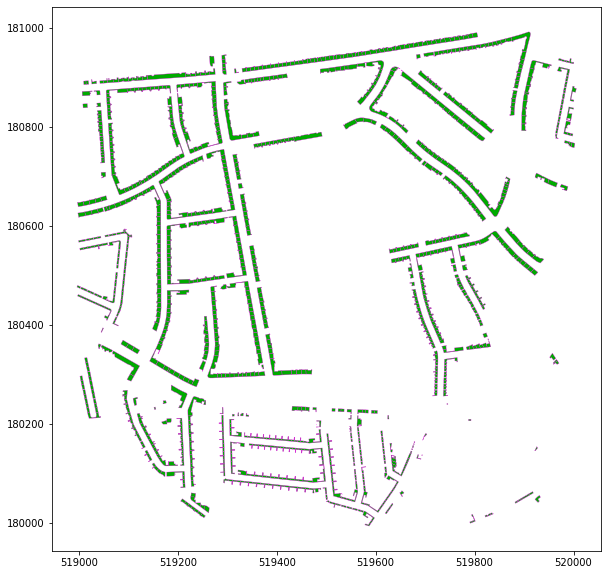

In [127]:
cg.plot(figsize = (10,10), color = '#00AA00', edgecolor = 'magenta', linewidth = 0.3)

## Jigsaw function

Changes from ppp07 and ppp08 added grid, folder_path and toid_col_name as inputs; these were hardcoded previously. Folder must exist already. Name of geometry column as 'geometry' is still hardcoded. Built in try, except, pass clause to deal with any errors; just do nothing and go on to the next one. Had a weird error where a garden was not in this grid - don't know how it got in... I did cut the vector data by hand in QGIS so probably got it that way, but I don't know why it didn't cause a problem before now...

Inputs
- raster: raster object of aerial photography, already loaded
- gdf: gdf object of gardens, already loaded
- folder_path: string, the path to the extant folder to stash all the images in
- grid: string, the BNG 1 km grid, eg TQ1980 to use in filename
- toid_col_name: string, the name of the column containing the shape ID, TOID in OSMM, but I have renamed it sometimes to distinguish between garden TOIDs and roadside TOIDs for example.


In [170]:
def jigsaw(raster, gdf, folder_path, grid, toid_col_name = 'TOID'):
    
    #set meta data
    im_meta = raster.meta
    
    for i in np.arange(gdf.shape[0]):
        
        g = gdf.copy(deep=True).iloc[i:i+1] #create single row gdf from gdf
        
        #try to run the mask on the shapes. Somehow some shapes may not be in the grid
        #so have built a pass to do nothing if this happens
        try:
            #use rasterio.mask.mask from rasterio.mask import mask must be run
            #im: raster np array, im_transform: transform 
            im, im_transform = mask(dataset = raster
                                    , shapes = g.geometry #assumes geometry column is named geometry
                                    , crop = True #crop to North and East extent of image
                                    , all_touched = True #include a pixel if it touches any of the shapes
                                    , nodata = 255 #set nodata value for all RGB layers, 255 = white, 0 = black
                                    , filled = True 
                                   )
        
            #update meta data
            im_meta.update({"driver": "GTiff"
                            , "height": im.shape[1]
                            ,"width": im.shape[2]
                            ,"transform": im_transform})
        
            #create filename
            filename = folder_path + "/" + grid + "_" + g[toid_col_name].iloc[0] + ".tif"
        
            #write to tif
            with rasterio.open(filename, mode = "w", **im_meta) as dest:
                dest.write(im)
        
            #plot.show(im)
        
        #if any errors occur in the above just do nothing and move on to the next one
        except:
            pass
        

## Jigsaw RGB with cropped garden polygons

Returned 1328 images, so only that one at row 646, with gdnTOID = 1000001778708000 was outside the area.

In [171]:
jigsaw(
    raster = rgb
    , gdf = cg
    , folder_path = '../jigsaw_output/rgb_gdn_cropped'
    , grid = ealing_tif_paths[10][-10:-4]
    , toid_col_name = 'gdnTOID'
)

## Jigsaw IRG with cropped garden polygons

Returned 1328 images, so only that one at row 646, with gdnTOID = 1000001778708000 was outside the area.

In [173]:
jigsaw(
    raster = irg
    , gdf = cg
    , folder_path = '../jigsaw_output/irg_gdn_cropped'
    , grid = ealing_tif_paths[10][-10:-4]
    , toid_col_name = 'gdnTOID'
)

## WindowError at row 646

Looks like the buffered images may cause a few shapes to now fall outside the TQ1980 grid. No that doesn't make sense. The cropped images are not bigger than the gardens they come from... Unless a corner one has magically added something? None of the gardens were previosuly outside the raster image.

Don't understand how but this polygon is indeed outside the TQ1980 grid, and actually in TQ1979... All its y coordinates are less than 180000.

so. weird.


In [142]:
g = cg.copy(deep=True).iloc[646:647]

In [172]:
g.head()

,gdnTOID,geometry
646,1000001778708000,"POLYGON ((519578.248 179995.418, 519578.508 17..."


In [167]:
g.geometry.iloc[0].area

31.717178328908442

In [166]:
g.geometry.iloc[0].exterior.coords.xy[1]

array('d', [179995.4176412176, 179996.2026484574, 179997.0095144533, 179997.5379713501, 179996.3499999996, 179997.4000000004, 179995.1999999993, 179999.75, 179998.3000000007, 179992.9499999993, 179994.4499999993, 179995.4176412176])

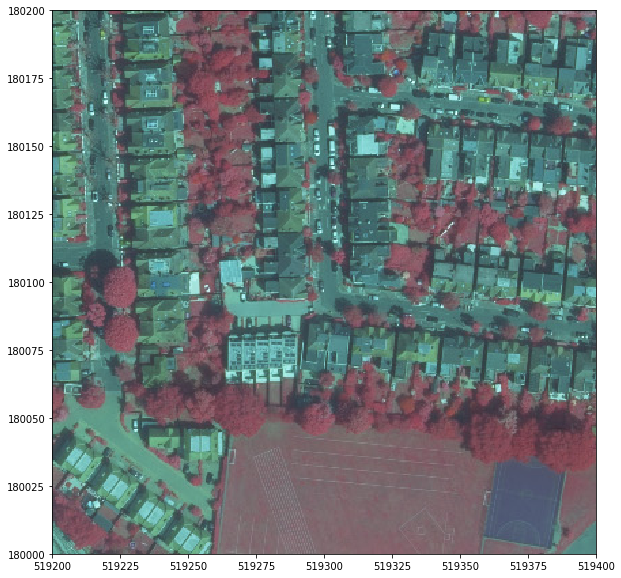

In [147]:
base = g.plot(figsize=(10,10), color = '#00FF00')
base.set_xlim(519577, 519595)
base.set_ylim(180000, 180200)
plot.show(irg, ax = base) #uses rasterio plot module


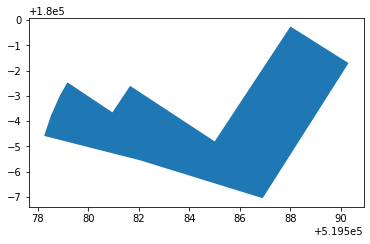

In [134]:
g.plot()

In [107]:
g

,gdnTOID,geometry
0,0001000003513170,"POLYGON ((519327.150 180219.550, 519329.100 18..."


In [112]:
type(cg)

geopandas.geodataframe.GeoDataFrame

In [113]:
type(g)

geopandas.geodataframe.GeoDataFrame

In [114]:
g.head()


,gdnTOID,geometry
0,0001000003513170,"POLYGON ((519327.150 180219.550, 519329.100 18..."
